In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
! echo $JAVA_HOME
! echo $SPARK_HOME
! echo $PYTHONPATH

/Library/Java/JavaVirtualMachines/jdk1.8.0_192.jdk/Contents/Home
/Users/Spark
/Users/Spark/python:/Users/Spark/python/lib/py4j-0.10.7-src.zip


In [3]:
import os
import sys
print(sys.executable)
print(os.environ['JAVA_HOME'])
print(os.environ['SPARK_HOME'])

/anaconda3/envs/ada/bin/python
/Library/Java/JavaVirtualMachines/jdk1.8.0_192.jdk/Contents/Home
/Users/Spark


In [4]:
import pandas as pd
import numpy as np

from pyspark.sql import *
#spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *
#from pyspark.sql.types import IntegerType
#from pyspark.sql.types import StringType
#from pyspark.sql.types import BooleanType

from pyspark.sql.functions import explode
from pyspark.sql.functions import split

from pyspark.sql.functions import udf
#from pyspark.sql.functions import col

import matplotlib.pyplot as plt

#from itertools import cycle, islice

In [5]:
spark = SparkSession.builder.getOrCreate()

# Openfoodfact data 

In [6]:
df_data = spark.read.option("sep", "\t").option("header", True).csv('./data.csv')

In [4]:
df_data

DataFrame[code: string, url: string, creator: string, created_t: string, created_datetime: string, last_modified_t: string, last_modified_datetime: string, product_name: string, generic_name: string, quantity: string, packaging: string, packaging_tags: string, brands: string, brands_tags: string, categories: string, categories_tags: string, categories_en: string, origins: string, origins_tags: string, manufacturing_places: string, manufacturing_places_tags: string, labels: string, labels_tags: string, labels_en: string, emb_codes: string, emb_codes_tags: string, first_packaging_code_geo: string, cities: string, cities_tags: string, purchase_places: string, stores: string, countries: string, countries_tags: string, countries_en: string, ingredients_text: string, allergens: string, allergens_en: string, traces: string, traces_tags: string, traces_en: string, serving_size: string, serving_quantity: string, no_nutriments: string, additives_n: string, additives: string, additives_tags: stri

In [39]:
countries = df_data.select(explode(split('countries_tags', ','))).withColumnRenamed("col", "countries_tags")
#countries.show(200)

counted_countries = countries.groupBy('countries_tags').count().sort("count", ascending = False)
counted_countries.show()

+-----------------+------+
|   countries_tags| count|
+-----------------+------+
|        en:france|446394|
| en:united-states|175478|
|       en:germany| 19489|
|   en:switzerland| 19365|
|       en:belgium|  9735|
|         en:spain|  8341|
|en:united-kingdom|  8086|
|        en:canada|  3805|
|         en:italy|  3035|
|     en:australia|  2694|
|        en:mexico|  2360|
|        en:russia|  2203|
|   en:netherlands|  1548|
|        en:sweden|  1526|
|      en:portugal|  1441|
|       en:denmark|   949|
|       en:austria|   928|
|       en:romania|   799|
|en:czech-republic|   646|
|       en:hungary|   643|
+-----------------+------+
only showing top 20 rows



In [36]:
categories = df_data.select(explode(split('categories_tags', ','))).withColumnRenamed("col", "categories_tags")
#categories.show(200, False)

counted_categories = categories.groupBy('categories_tags').count().sort("count", ascending = False)
counted_categories.show(200, False)

+------------------------------------+-----+
|categories_tags                     |count|
+------------------------------------+-----+
|en:plant-based-foods-and-beverages  |51261|
|en:plant-based-foods                |43981|
|en:beverages                        |29798|
|en:sugary-snacks                    |26277|
|en:dairies                          |18477|
|en:non-alcoholic-beverages          |16523|
|en:meals                            |15601|
|en:fruits-and-vegetables-based-foods|15362|
|en:cereals-and-potatoes             |15324|
|en:fermented-foods                  |12164|
|en:fermented-milk-products          |12127|
|en:biscuits-and-cakes               |11895|
|en:spreads                          |10928|
|en:cereals-and-their-products       |9792 |
|en:meats                            |9686 |
|en:groceries                        |9583 |
|en:breakfasts                       |9547 |
|en:desserts                         |9091 |
|en:plant-based-beverages            |8633 |
|en:fruits

In [47]:
#We define the colors corresponding to the Nutri-score for our following plots

score_colors =['green', 'lightgreen', 'yellow', 'orange','red']

# France data

### Overall

In [4]:
df_france = df_data.where(df_data.countries_tags.contains('en:france')).select('product_name','categories_tags','nutrition_grade_fr', 'nutrition-score-fr_100g')
#df_france.show(200)

In [26]:
df_france.count()

446394

In [41]:
df_france = df_france.na.drop()
df_france.show(200)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|  Tarte noix de coco|en:pies,en:sweet-...|                 d|                     14|
|    Compote de poire|en:plant-based-fo...|                 a|                     -4|
|    BAguette bressan|en:plant-based-fo...|                 a|                     -4|
|Pavé de saumon fu...|en:seafood,en:fis...|                 d|                     15|
|  Stylo glaçage gris| en:food-decorations|                 e|                     29|
|Blanquette de Vol...|en:meals,en:meat-...|                 b|                      0|
|Raviolini au From...|en:meals,en:micro...|                 b|                      1|
|           Root Beer|en:beverages,en:c...|                 e|                     12|
|A&w - Root Beer -...|en:beverages,en:n...|

In [24]:
total_france = df_france.count()
total_france

116780

In [9]:
counted_nutriscore = df_france.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
counted_nutriscore.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|15270|
|                 b|16192|
|                 c|24137|
|                 d|34280|
|                 e|26901|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

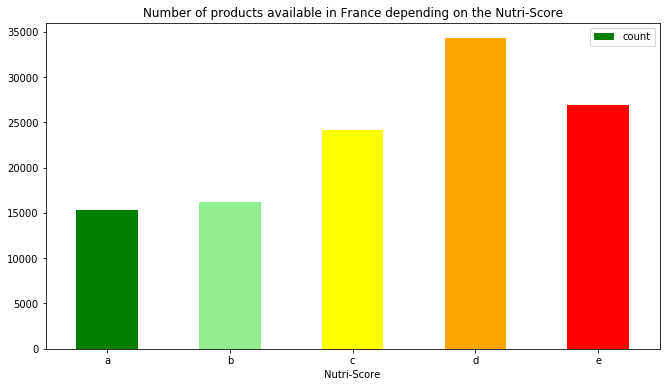

In [10]:
pd_nutriscore_france = counted_nutriscore.toPandas()

pd_nutriscore_france.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color=score_colors)
plt.title("Number of products available in France depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

### Beverages

In [43]:
france_beverages = df_france.filter(df_france.categories_tags.contains("en:beverages"))
#france_beverages.show(200)

In [44]:
france_beverages.count()

15419

In [49]:
beverage_nutriscore = france_beverages.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
beverage_nutriscore.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|  238|
|                 b| 2632|
|                 c| 2826|
|                 d| 2495|
|                 e| 7228|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

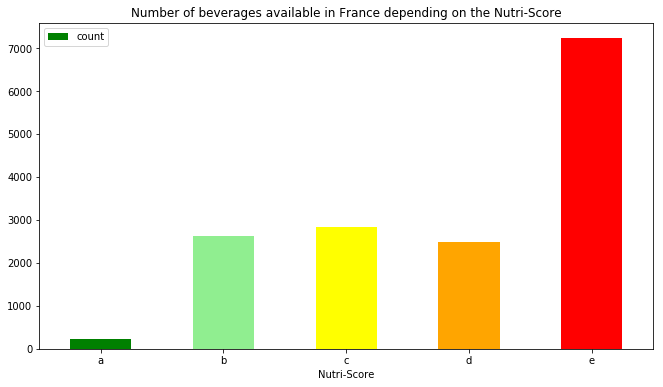

In [50]:
pd_beverages_france = beverage_nutriscore.toPandas()

pd_beverages_france.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color=score_colors)
plt.title("Number of beverages available in France depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

# Switzerland data

In [11]:
df_switzerland = df_data.where(df_data.countries_tags.contains('en:switzerland')).select('product_name','categories_tags','nutrition_grade_fr', 'nutrition-score-fr_100g')
#df_switzerland.show(200)

In [44]:
df_switzerland.count()

19365

In [12]:
df_switzerland = df_switzerland.na.drop()
df_switzerland.show(200)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|             Nutella|en:petit-dejeuner...|                 e|                     24|
|                skyr|en:dairies,en:fer...|                 a|                     -5|
|Chocolate Chunk D...|en:sugary-snacks,...|                 e|                     21|
|Chocolate Chunk M...|en:sugary-snacks,...|                 e|                     22|
|Poires demi-fruit...|en:plant-based-fo...|                 a|                     -3|
|  Pêches Demi-Fruits|en:plant-based-fo...|                 a|                     -3|
|Cocktail de fruit...|en:plant-based-fo...|                 a|                     -3|
|Mandarines au sir...|en:plant-based-fo...|                 a|                     -3|
|  Cocktail de fruits|en:plant-based-fo...|

In [23]:
total_switz = df_switzerland.count()
total_switz

4463

Each time we have the Nutri-score for about 1/4 of the datas.

In [13]:
counted_nutriscore_s = df_switzerland.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
counted_nutriscore_s.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|  723|
|                 b|  664|
|                 c|  897|
|                 d| 1220|
|                 e|  959|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

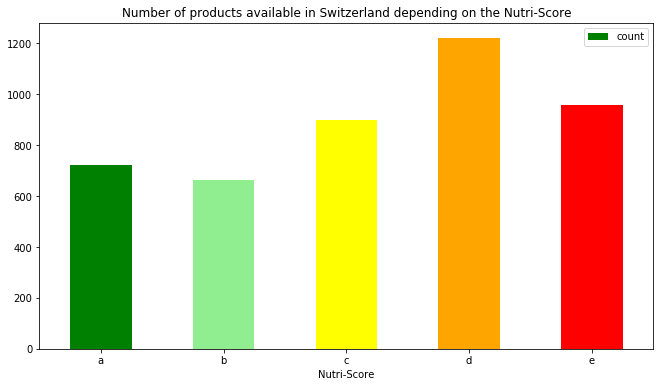

In [14]:
pd_nutriscore_switzerland = counted_nutriscore_s.toPandas()

pd_nutriscore_switzerland.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color= score_colors)
plt.title("Number of products available in Switzerland depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

# United states datas

In [15]:
df_usa = df_data.where(df_data.countries_tags.contains('en:united-states')).select('product_name','categories_tags','nutrition_grade_fr', 'nutrition-score-fr_100g')
#df_usa.show(200)

In [54]:
df_usa.count()

175479

In [16]:
df_usa = df_usa.na.drop()
df_usa.show(200)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|           Root Beer|en:beverages,en:c...|                 e|                     12|
|  Sliced Plain Bagel|      en:pains-bagel|                 c|                      3|
|Sea Salt Potato C...|en:chips-and-frie...|                 c|                      8|
|        clam chowder|en:meals,en:soups...|                 b|                      2|
|      Pizza Parlanno|en:meals,en:pizza...|                 d|                     11|
|       Mac 'n Cheese|en:meals,en:micro...|                 c|                      4|
|      Yellow Mustard|en:groceries,en:c...|                 b|                      0|
|Vanilla Nonfat Yo...|en:dairies,en:fer...|                 a|                     -1|
|          Tortellini|en:plant-based-fo...|

In [22]:
total_usa = df_usa.count()
total_usa

2685

In [17]:
counted_nutriscore_usa = df_usa.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
counted_nutriscore_usa.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|  336|
|                 b|  432|
|                 c|  496|
|                 d|  862|
|                 e|  559|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

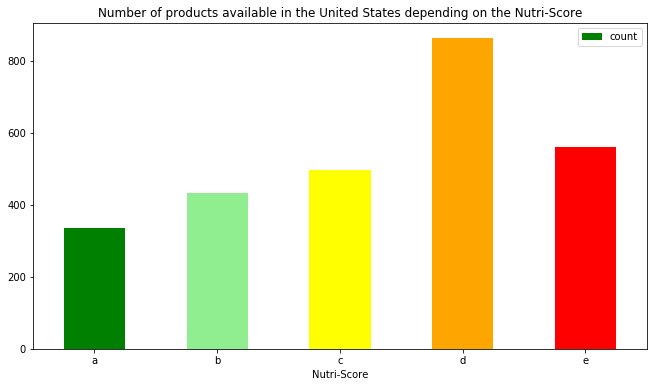

In [18]:
pd_nutriscore_usa = counted_nutriscore_usa.toPandas()

pd_nutriscore_usa.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color= score_colors)
plt.title("Number of products available in the United States depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

# Overall comparison

In [57]:
nb_lines = len(pd_nutriscore_france.iloc[:,0])

France_percent = []
Switzerland_percent = []
United_States_percent = []
nutri_score = []

for i in range (0, nb_lines):
    nutri_score.append(pd_nutriscore_france.index[i])
    France_percent.append(pd_nutriscore_france.iloc[i,0]/total_france*100)
    Switzerland_percent.append(pd_nutriscore_switzerland.iloc[i,0]/total_switz*100)
    United_States_percent.append(pd_nutriscore_usa.iloc[i,0]/total_usa*100)


In [58]:
df_comparison = pd.DataFrame({'France': France_percent, 'Switzerland': Switzerland_percent, 'United States': United_States_percent, 'Nutri-score': nutri_score}).set_index('Nutri-score')

df_comparison

,France,Switzerland,United States
Nutri-score,,,
a,13.075869,16.199866,12.513966
b,13.865388,14.877885,16.089385
c,20.668779,20.098588,18.472998
d,29.354341,27.335873,32.104283
e,23.035623,21.487788,20.819367


Text(0, 0.5, 'Percentage')

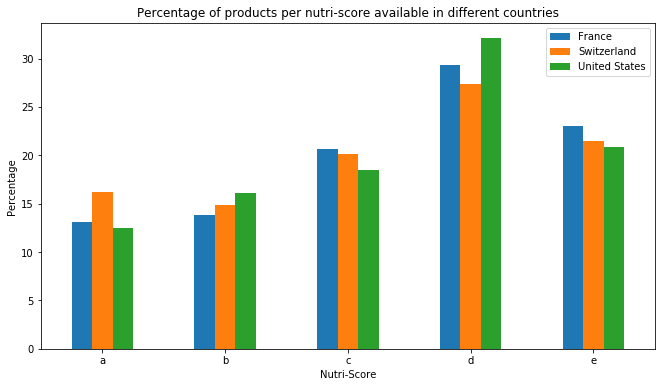

In [60]:
df_comparison.plot.bar(rot=0, figsize=(11,6))

plt.title("Percentage of products per nutri-score available in different countries")
plt.xlabel("Nutri-Score")
plt.ylabel("Percentage")

# # Brouillou

In [ ]:
from sklearn.preprocessing import normalize

In [32]:
pd_nutriscore_france = pd_nutriscore_france.rename(columns={'count': 'France'}).set_index('nutrition_grade_fr')
pd_nutriscore_switzerland = pd_nutriscore_switzerland.rename(columns={'count': 'Switzerland'}).set_index('nutrition_grade_fr')
pd_nutriscore_usa = pd_nutriscore_usa.rename(columns={'count': 'United States'}).set_index('nutrition_grade_fr')

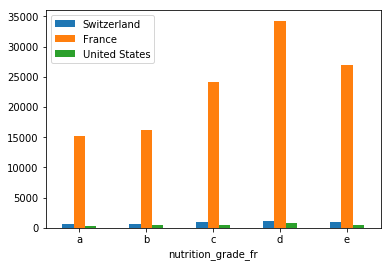

In [34]:
df_comparison = pd.concat([pd_nutriscore_switzerland, pd_nutriscore_france, pd_nutriscore_usa], axis=1, join_axes=[pd_nutriscore_switzerland.index])
#df_comparison = normalize(df_comparison, axis=0)
df_comparison
df_comparison.plot.bar(rot=0)

In [62]:
query = """
SELECT *
FROM df_france
WHERE categories_tags
RLIKE 'en:beverages.*'
"""

france_beverages = spark.sql(query)
france_beverages.show(200)


# Vérifier les imports !!!

AnalysisException: 'Table or view not found: df_france; line 3 pos 5'